In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
filename="your location text8.zip"
words = read_data(filename)
#words = tf.compat.as_str(read()).split()
print('Data size %d' % len(words))

Data size 17005207


In [3]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5240, 3083, 12, 6, 195, 2, 3134, 46, 59, 156]


In [29]:
data_index = 0

def generate_batch(batch_size, skip_window):
  global data_index
#   assert batch_size % num_skips == 0
#   assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size, skip_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)

  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size):
    batch[i] = list(buffer)[:skip_window] + list(buffer)[skip_window+1:]
    labels[i] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels
print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in [1,2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, skip_window=skip_window)
    print('\nwith skip_window = %d:' % skip_window)
    print("Embedding Matrix:")
    print(batch)
    print("Embedding Matrix in words:")
    for i, j in enumerate(batch):
        print('batch row № {}:'.format(i+1), [reverse_dictionary[bi] for bi in j])
    print('labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with skip_window = 1:
Embedding Matrix:
[[5240   12]
 [3083    6]
 [  12  195]
 [   6    2]
 [ 195 3134]
 [   2   46]
 [3134   59]
 [  46  156]]
Embedding Matrix in words:
batch row № 1: ['anarchism', 'as']
batch row № 2: ['originated', 'a']
batch row № 3: ['as', 'term']
batch row № 4: ['a', 'of']
batch row № 5: ['term', 'abuse']
batch row № 6: ['of', 'first']
batch row № 7: ['abuse', 'used']
batch row № 8: ['first', 'against']
labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with skip_window = 2:
Embedding Matrix:
[[5240 3083    6  195]
 [3083   12  195    2]
 [  12    6    2 3134]
 [   6  195 3134   46]
 [ 195    2   46   59]
 [   2 3134   59  156]
 [3134   46  156  128]
 [  46   59  128  742]]
Embedding Matrix in words:
batch row № 1: ['anarchism', 'originated', 'a', 'term']
batch row № 2: ['originated', 'as', 'term', 'of']
batch row № 3: ['as', 'a', 'of', 'abuse']
batch row № 4: 

Train a Continuous Bag of Words model.

In [33]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
# Want to test 2 as skip_window 
# num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,skip_window*2]) # Embedding matrix shape batch_size*window_size
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset), 1) #Sum(g(embeddings))
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights = softmax_weights,
                               biases = softmax_biases,
                               inputs = embed,
                               labels = train_labels,
                               num_sampled = num_sampled,
                               num_classes = vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [35]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.023680
Nearest to from: enlist, craze, lusaka, molten, letterboxing, petals, dichotomy, till,
Nearest to time: musicologist, respected, tetragrammaton, crudely, postseason, fiore, concerns, iv,
Nearest to it: ramayana, reuters, peh, disregard, reorganisation, kalamazoo, brod, maker,
Nearest to united: bounded, inductors, lct, howl, patten, coast, jude, equivalent,
Nearest to states: chronological, mlm, toei, ivar, cannes, fergana, glorifying, abdera,
Nearest to first: hydrophobic, xxii, gravitation, bendix, static, kashima, unaccustomed, regain,
Nearest to known: acuity, jaffe, contests, architecturally, centro, conic, all, freer,
Nearest to his: bytes, alexandria, hanna, rearrangement, gion, vestments, outright, burney,
Nearest to into: leucine, fluctuating, expunged, squaring, cause, likened, mordred, transfusion,
Nearest to which: swimming, leiserson, entanglements, guido, int, vip, ilinden, benchmarks,
Nearest to UNK: precipitates, arabians, al

In [36]:
num_points = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

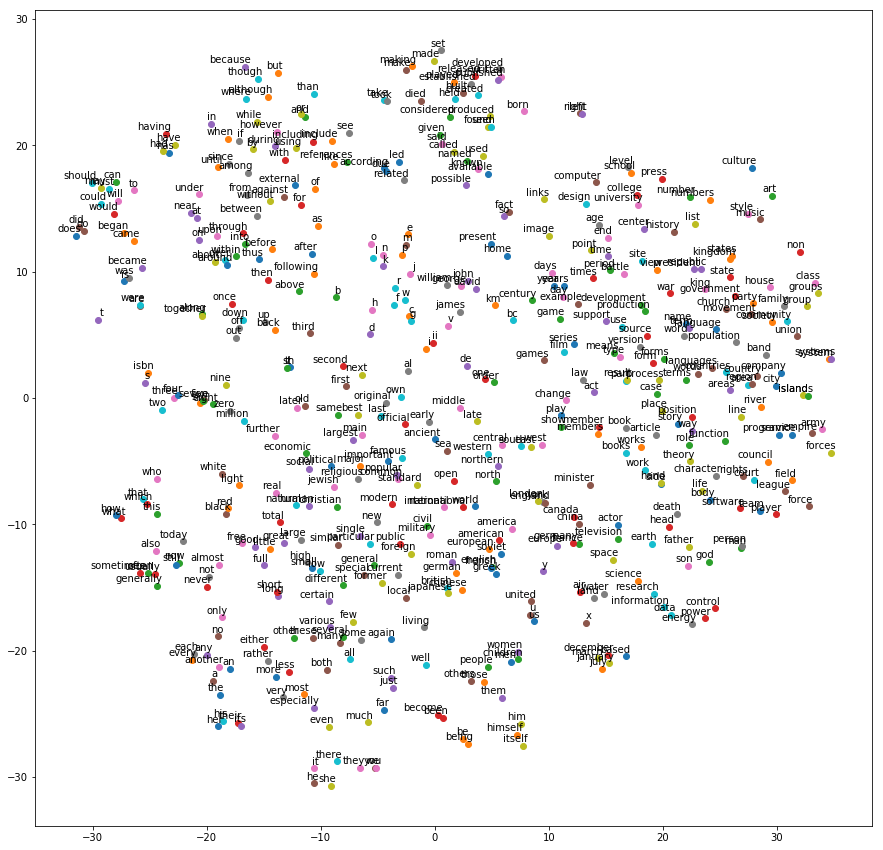

In [37]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)